- [Main code](#main-code)
- [Step by step code](#step-by-step-code)

### Main code

In [18]:
"""
Now do the prediction
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from PIL import Image

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
resnet50_model = resnet50_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
fc_state_dict = torch.load("./data/09_Images/fc_model_3.pth", weights_only=True)
fc_model.load_state_dict(fc_state_dict)
fc_model = fc_model.to(device)

model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)
model.eval()

tire = Image.open("./data/09_Images/prediction/tire3.jpg")
tire_tensor = preprocess(tire)
# print(tire1_tensor)
# print(tire1_tensor.shape)
tire_tensor = tire_tensor.unsqueeze(dim=0)
# print(tire1_tensor)
# print(tire1_tensor.shape)
tire_tensor = tire_tensor.to(device)

with torch.no_grad():
    y_pred = torch.sigmoid(model(tire_tensor))
    print(y_pred)
    pass

Using device: xpu
tensor([[0.0012]], device='xpu:0')


### Step by step code

In [1]:
"""
Basic Resnet code
Doc. Ref.: https://pytorch.org/hub/pytorch_vision_resnet/
"""

import sys
import torch
import torchvision

from PIL import Image
from torchvision import transforms

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True) # Mentioned in pytorch website
# model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT) # Default resnet model
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.eval()

filename = "./data/09_Images/cat.jpg"
input_image = Image.open(filename)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


input_batch = input_batch.to(device)
model.to(device)

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

# Read the categories
with open("./data/09_Images/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


Using device: xpu
Egyptian cat 0.6402460932731628
plastic bag 0.08858644962310791
tiger cat 0.08119015395641327
sleeping bag 0.07152608036994934
tabby 0.029940713196992874


In [2]:
print(top5_prob)

tensor([0.6402, 0.0886, 0.0812, 0.0715, 0.0299], device='xpu:0')


In [3]:
print(top5_catid)

tensor([285, 728, 282, 797, 281], device='xpu:0')


In [4]:
"""
Load the data now
"""

import sys
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images/',
    transform=preprocess
)
print(dataset.class_to_idx)
print(dataset[1400])

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(val_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)


{'defective': 0, 'good': 1}
(tensor([[[-0.2342, -0.1143,  0.1254,  ..., -0.4911, -0.4568, -0.4911],
         [-0.2856, -0.0629,  0.0741,  ..., -0.4911, -0.4568, -0.3712],
         [-0.2684, -0.0287, -0.0287,  ..., -0.4397, -0.4568, -0.3198],
         ...,
         [-0.3369, -0.2856, -0.1486,  ..., -0.6965, -0.7993, -0.7650],
         [-0.1143, -0.0287,  0.1597,  ..., -0.6109, -0.6965, -0.6623],
         [ 0.4679,  0.6563,  0.7762,  ..., -0.4054, -0.4568, -0.4397]],

        [[-0.0399,  0.1001,  0.3277,  ..., -0.2150, -0.1800, -0.2150],
         [-0.0924,  0.1352,  0.2927,  ..., -0.2500, -0.2150, -0.1099],
         [-0.0924,  0.1527,  0.1877,  ..., -0.1975, -0.1800, -0.0399],
         ...,
         [-0.0224,  0.0476,  0.1702,  ..., -0.3725, -0.4776, -0.4601],
         [ 0.1877,  0.2927,  0.4853,  ..., -0.3025, -0.4076, -0.3901],
         [ 0.7479,  0.9580,  1.0805,  ..., -0.1099, -0.1800, -0.1625]],

        [[ 0.0256,  0.2173,  0.4962,  ..., -0.0615, -0.0092, -0.0267],
         [-0.061

In [6]:
import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images/',
    transform=preprocess
)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity() # Instead of removing the fully connected layer. We'll replace fc layer with nn.Identity() layer.
resnet50_model.eval()

for X, y in train_dataloader:
    print(resnet50_model(X).shape)
    print(resnet50_model(X))
    break



torch.Size([32, 2048])
tensor([[0.0336, 0.6679, 0.1666,  ..., 0.4760, 0.5207, 0.3837],
        [0.1866, 0.1911, 0.0767,  ..., 0.2048, 0.0745, 0.1339],
        [0.3993, 0.2582, 0.3951,  ..., 0.0889, 0.1884, 0.3733],
        ...,
        [0.2678, 1.3730, 0.0567,  ..., 0.3261, 0.4469, 0.8907],
        [0.7721, 1.1602, 0.3235,  ..., 0.1784, 0.2367, 0.5428],
        [0.0028, 0.4231, 0.0084,  ..., 0.0350, 0.1405, 0.2168]],
       grad_fn=<ViewBackward0>)


In [8]:
"""
model transfer
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images/',
    transform=preprocess
)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval()

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)

model = nn.Sequential(
    resnet50_model,
    fc_model
)

optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

print(model)

for X, y in train_dataloader:
    out = model(X)
    print(out.shape)
    break



Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [9]:
"""
Model training
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images/',
    transform=preprocess
)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval()
resnet50_model = resnet50_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
fc_model = fc_model.to(device)

model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)

optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(10):
    
    loss_sum = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float).reshape(-1, 1)

        outputs = model(X)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()
    print(loss_sum)



Using device: xpu
19.529963448643684
9.51763753220439
8.801081113517284
6.877262387424707
6.687844231724739
6.036806099116802
5.204704511910677
6.267987970262766
3.9412702145054936
3.2025185767561197


In [10]:
"""
Model training 2
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images/',
    transform=preprocess
)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval()
resnet50_model = resnet50_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
fc_model = fc_model.to(device)

model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)

optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.00025)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(10):
    model.train()
    resnet50_model.eval()
    
    loss_sum = 0
    train_accurate = 0
    train_sum = 0
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float).reshape(-1, 1)

        outputs = model(X)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()

        predictions = torch.sigmoid(outputs) > 0.5
        accurate = (predictions == y).sum().item()
        train_accurate+=accurate
        train_sum+=y.size(0)
    print("Training loss: ", loss_sum / len(train_dataloader))
    print("Training accuracy: ", train_accurate / train_sum)


    model.eval()
    val_loss_sum = 0
    val_accurate = 0
    val_sum = 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X = X.to(device)
            y = y.to(device).type(torch.float).reshape(-1, 1)

            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss_sum+=loss.item()

            predictions = torch.sigmoid(outputs) > 0.5
            accurate = (predictions == y).sum().item()
            val_accurate+=accurate
            val_sum+=y.size(0)
    print("Validation loss: ", val_loss_sum / len(val_dataloader))
    print("Validation accuracy: ", val_accurate / val_sum)


Using device: xpu
Training loss:  0.335767554792952
Training accuracy:  0.8417508417508418
Validation loss:  0.2318673146267732
Validation accuracy:  0.9191374663072777
Training loss:  0.20077281778163097
Training accuracy:  0.9151515151515152
Validation loss:  0.1930123958736658
Validation accuracy:  0.9245283018867925
Training loss:  0.15930183255609046
Training accuracy:  0.94006734006734
Validation loss:  0.18241715617477894
Validation accuracy:  0.9353099730458221
Training loss:  0.13320306831217826
Training accuracy:  0.9562289562289562
Validation loss:  0.17697014256070057
Validation accuracy:  0.9353099730458221
Training loss:  0.1328073742383338
Training accuracy:  0.9521885521885521
Validation loss:  0.2291285196940104
Validation accuracy:  0.9029649595687331
Training loss:  0.128340371270129
Training accuracy:  0.9474747474747475
Validation loss:  0.28640378390749294
Validation accuracy:  0.8787061994609164
Training loss:  0.10056740972906986
Training accuracy:  0.9589225589

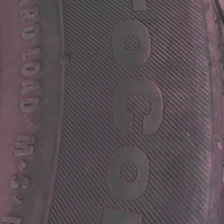

In [11]:
"""
Overfitting may occur, as we have lesser data.
So we don't have more data to train. So use existing data.
Transform and generate new images
"""

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from PIL import Image

preprocess = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open("./data/09_Images/good/good (9).jpg")
preprocess(image)

In [12]:
"""
Now add the training data.
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(
    root='./data/09_Images',
    transform=preprocess
)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval()
resnet50_model = resnet50_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
fc_model = fc_model.to(device)

model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)

optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.00025)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(15):
    print(f"--- EPOCH: {epoch} ---")
    model.train()
    resnet50_model.eval()
    
    loss_sum = 0
    train_accurate = 0
    train_sum = 0
    for X, y in tqdm(train_dataloader):
        X = X.to(device)
        y = y.to(device).type(torch.float).reshape(-1, 1)

        outputs = model(X)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        loss_sum+=loss.item()
        loss.backward()
        optimizer.step()

        predictions = torch.sigmoid(outputs) > 0.5
        accurate = (predictions == y).sum().item()
        train_accurate+=accurate
        train_sum+=y.size(0)
    print("Training loss: ", loss_sum / len(train_dataloader))
    print("Training accuracy: ", train_accurate / train_sum)


    torch.save(fc_model.state_dict(), f"fc_model_{epoch}.pth")

    model.eval()
    val_loss_sum = 0
    val_accurate = 0
    val_sum = 0
    with torch.no_grad():
        for X, y in tqdm(val_dataloader):
            X = X.to(device)
            y = y.to(device).type(torch.float).reshape(-1, 1)

            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss_sum+=loss.item()

            predictions = torch.sigmoid(outputs) > 0.5
            accurate = (predictions == y).sum().item()
            val_accurate+=accurate
            val_sum+=y.size(0)
    print("Validation loss: ", val_loss_sum / len(val_dataloader))
    print("Validation accuracy: ", val_accurate / val_sum)

Using device: xpu
--- EPOCH: 0 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:02<00:00,  2.61s/it]


Training loss:  0.33478361431588516
Training accuracy:  0.8572390572390572


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.54s/it]


Validation loss:  0.22818842406074205
Validation accuracy:  0.9056603773584906
--- EPOCH: 1 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:05<00:00,  2.67s/it]


Training loss:  0.2078779344546034
Training accuracy:  0.907070707070707


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.68s/it]


Validation loss:  0.24489726622899374
Validation accuracy:  0.8921832884097035
--- EPOCH: 2 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:04<00:00,  2.66s/it]


Training loss:  0.2107811668451796
Training accuracy:  0.9144781144781144


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.72s/it]


Validation loss:  0.26162708178162575
Validation accuracy:  0.8840970350404312
--- EPOCH: 3 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:03<00:00,  2.62s/it]


Training loss:  0.19367148156495803
Training accuracy:  0.9225589225589226


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.64s/it]


Validation loss:  0.2035110785315434
Validation accuracy:  0.9110512129380054
--- EPOCH: 4 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:05<00:00,  2.66s/it]


Training loss:  0.15702663354100066
Training accuracy:  0.934006734006734


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.64s/it]


Validation loss:  0.23202294949442148
Validation accuracy:  0.9164420485175202
--- EPOCH: 5 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:03<00:00,  2.63s/it]


Training loss:  0.15406728845010412
Training accuracy:  0.9326599326599326


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.70s/it]


Validation loss:  0.14195101195946336
Validation accuracy:  0.9407008086253369
--- EPOCH: 6 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:05<00:00,  2.67s/it]


Training loss:  0.1409106674663564
Training accuracy:  0.9427609427609428


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.59s/it]


Validation loss:  0.18800713556508222
Validation accuracy:  0.921832884097035
--- EPOCH: 7 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:05<00:00,  2.66s/it]


Training loss:  0.1413612593203149
Training accuracy:  0.9461279461279462


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:32<00:00,  2.68s/it]


Validation loss:  0.15613140972952047
Validation accuracy:  0.9272237196765498
--- EPOCH: 8 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:02<00:00,  2.61s/it]


Training loss:  0.13992134568856118
Training accuracy:  0.9474747474747475


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:33<00:00,  2.77s/it]


Validation loss:  0.15532356345405182
Validation accuracy:  0.9272237196765498
--- EPOCH: 9 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:06<00:00,  2.70s/it]


Training loss:  0.12090985940650423
Training accuracy:  0.9542087542087542


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.62s/it]


Validation loss:  0.17062187132736048
Validation accuracy:  0.9299191374663073
--- EPOCH: 10 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:05<00:00,  2.67s/it]


Training loss:  0.11666833474598032
Training accuracy:  0.9569023569023569


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.65s/it]


Validation loss:  0.15759600512683392
Validation accuracy:  0.9460916442048517
--- EPOCH: 11 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:03<00:00,  2.63s/it]


Training loss:  0.11995246289099784
Training accuracy:  0.960942760942761


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.62s/it]


Validation loss:  0.1689252957391242
Validation accuracy:  0.9326145552560647
--- EPOCH: 12 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:00<00:00,  2.56s/it]


Training loss:  0.10830550846901346
Training accuracy:  0.9582491582491582


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.56s/it]


Validation loss:  0.17369929421693087
Validation accuracy:  0.9164420485175202
--- EPOCH: 13 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:01<00:00,  2.58s/it]


Training loss:  0.10537206817497598
Training accuracy:  0.9582491582491582


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.60s/it]


Validation loss:  0.18331425171345472
Validation accuracy:  0.9110512129380054
--- EPOCH: 14 ---


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:00<00:00,  2.57s/it]


Training loss:  0.12293699316363385
Training accuracy:  0.9535353535353536


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.56s/it]

Validation loss:  0.18072351720184088
Validation accuracy:  0.9272237196765498


In [14]:
"""
Adapting model weights for Universal compatibility
"""

import torch

weights = torch.load("fc_model_3.pth", weights_only=True, map_location="cpu")
torch.save(weights, "./data/09_Images/fc_model_3.pth")
print(weights)

OrderedDict({'0.weight': tensor([[ 0.0050,  0.0138,  0.0057,  ..., -0.0037, -0.0151,  0.0166],
        [-0.0009,  0.0169, -0.0065,  ...,  0.0111,  0.0083, -0.0181],
        [ 0.0077, -0.0076, -0.0025,  ..., -0.0133,  0.0173,  0.0163],
        ...,
        [ 0.0166, -0.0009, -0.0075,  ...,  0.0039,  0.0019, -0.0056],
        [ 0.0031,  0.0141, -0.0005,  ...,  0.0050,  0.0197, -0.0171],
        [-0.0172, -0.0189, -0.0035,  ..., -0.0157,  0.0108,  0.0006]]), '0.bias': tensor([-0.0061,  0.0015,  0.0086,  ..., -0.0143,  0.0148, -0.0024]), '2.weight': tensor([[-0.0187, -0.0193,  0.0122,  ...,  0.0282, -0.0251,  0.0048]]), '2.bias': tensor([0.0205])})


In [17]:
"""
Now do the prediction
"""

import sys
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from PIL import Image

if torch.cuda.is_available():
  device="cuda"
elif torch.xpu.is_available():
  device="xpu"
elif torch.mps.is_available():
  device="mps"    
else:
  device="cpu"

print("Using device:", device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
)
resnet50_model.fc = nn.Identity()
resnet50_model = resnet50_model.to(device)

fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)
fc_state_dict = torch.load("./data/09_Images/fc_model_3.pth", weights_only=True)
fc_model.load_state_dict(fc_state_dict)
fc_model = fc_model.to(device)

model = nn.Sequential(
    resnet50_model,
    fc_model
)
model = model.to(device)
model.eval()

tire = Image.open("./data/09_Images/prediction/tire3.jpg")
tire_tensor = preprocess(tire)
# print(tire1_tensor)
# print(tire1_tensor.shape)
tire_tensor = tire_tensor.unsqueeze(dim=0)
# print(tire1_tensor)
# print(tire1_tensor.shape)
tire_tensor = tire_tensor.to(device)

with torch.no_grad():
    y_pred = torch.sigmoid(model(tire_tensor))
    print(y_pred)
    pass

Using device: xpu
tensor([[0.0012]], device='xpu:0')
